In [31]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import glob
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib widget

list_of_files = [f for f in glob.glob('./data/*') if not os.path.isdir(f)] #take all files but not folders
latest_file = max(list_of_files, key=os.path.getctime)

file_path = latest_file
# file_path = "./data/0500um_110mm_c1_2023-12-15_20-56-08.txt"

# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

# Extract force and angle values from the lines
force_values = []
angle_values = []
for line in lines:
    if line.startswith('force'):
        force_values.append(float(line.split(': ')[1]))
    elif line.startswith('angle'):
        angle_values.append(float(line.split(': ')[1]))
    if line.startswith('end'): 
        break

# Create a dataframe from the extracted values
df = pd.DataFrame({'force': force_values, 'angle': angle_values})
df['force'] = df['force']*9.81

radius_fixed = 0.377
radius_swing = 0.377
df['dist'] = np.sqrt(radius_fixed**2 + radius_swing**2 - 2*radius_fixed*radius_swing*np.cos(np.radians(-df['angle'])))


trimmed_df = df[(np.abs(df['angle'] - trim_mean(df['angle'], 0.01)) / df['angle'].std() < 3)]
trimmed_df = trimmed_df.reset_index(drop=True)


# trimmed_df[:2000].plot('dist', 'force')

fig, ax = plt.subplots()

@interact(start_index=IntSlider(min=0, max=len(trimmed_df)-1, step=1, value=0),
          end_index=IntSlider(min=0, max=len(trimmed_df)-1, step=1, value=len(trimmed_df)-1))
def display_image(start_index, end_index):
    if(start_index >= end_index):
        return
    
    ax.clear()
    ax.set_xlabel('displacement (m)')
    ax.set_ylabel('force (N)')
    ax.plot(trimmed_df['dist'][start_index:end_index], trimmed_df['force'][start_index:end_index])

    objective_values = np.array([-trimmed_df['dist'][start_index:end_index], trimmed_df['force'][start_index:end_index]]).T

    pareto_front = []
    for i, (obj_val) in enumerate(objective_values):
        if all(np.any(obj_val <= objective_values[:], axis=1)):
            pareto_front.append(obj_val)
    pareto_front = np.array(pareto_front)
    pareto_front[:, 0] *= -1
    pareto_front = np.array(sorted(pareto_front, key=lambda x: x[0]))

    ax.fill_between(pareto_front.T[0], pareto_front.T[1], np.zeros_like(pareto_front.T[1]), color='lightblue', alpha=0.3)

    area_under_pareto_front = np.trapz(pareto_front.T[1], pareto_front.T[0])
    max_dist = max(pareto_front.T[0])
    # print(area_under_pareto_front)
    ax.set_title(f"{file_path}\n Energy storage: {round(area_under_pareto_front,3)} J at {round(max_dist,3)} m")


    plt.show()


interactive(children=(IntSlider(value=0, description='start_index', max=2228), IntSlider(value=2228, descripti…

/var/folders/fm/j5zsv9x1121cqbb30njg041r0000gn/T/ipykernel_65593/454613541.py:71: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


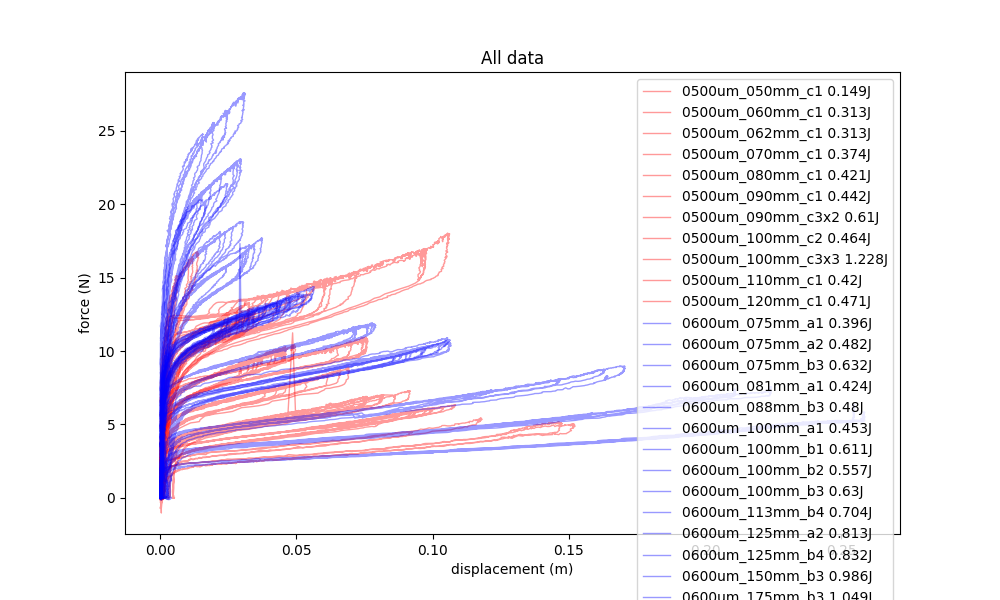

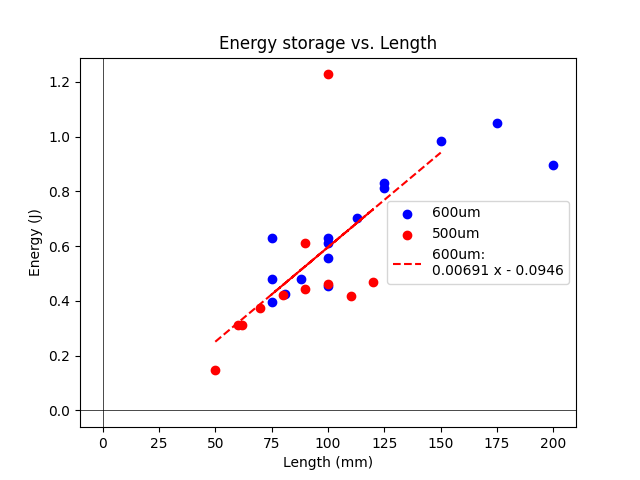

In [32]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import glob
import os
import re
import matplotlib.pyplot as plt
%matplotlib widget

list_of_files = [f for f in glob.glob('./data/*') if not os.path.isdir(f)] #take all files but not folders

thickness_length_energy = []

fig, ax = plt.subplots(figsize=(10,6))
ax.set_xlabel('displacement (m)')
ax.set_ylabel('force (N)')
ax.set_title("All data")

for file_path in sorted(list_of_files):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    force_values = []
    angle_values = []
    for line in lines:
        if line.startswith('force'):
            force_values.append(float(line.split(': ')[1]))
        elif line.startswith('angle'):
            angle_values.append(float(line.split(': ')[1]))
        if line.startswith('end'): 
            break

    # Create a dataframe from the extracted values
    df = pd.DataFrame({'force': force_values, 'angle': angle_values})
    df['force'] = df['force']*9.81

    radius_fixed = 0.377
    radius_swing = 0.377
    df['dist'] = np.sqrt(radius_fixed**2 + radius_swing**2 - 2*radius_fixed*radius_swing*np.cos(np.radians(-df['angle'])))


    trimmed_df = df[(np.abs(df['angle'] - trim_mean(df['angle'], 0.01)) / df['angle'].std() < 3)]
    trimmed_df = trimmed_df.reset_index(drop=True)

    objective_values = np.array([-trimmed_df['dist'], trimmed_df['force']]).T

    pareto_front = []
    for i, (obj_val) in enumerate(objective_values):
        if all(np.any(obj_val <= objective_values[:], axis=1)):
            pareto_front.append(obj_val)
    pareto_front = np.array(pareto_front)
    pareto_front[:, 0] *= -1
    pareto_front = np.array(sorted(pareto_front, key=lambda x: x[0]))

    # ax.fill_between(pareto_front.T[0], pareto_front.T[1], np.zeros_like(pareto_front.T[1]), alpha=0.3)
    area_under_pareto_front = np.trapz(pareto_front.T[1], pareto_front.T[0])

    thickness = float(re.search(r'(\d+)um', file_path).group(1))
    length = float(re.search(r'(\d+)mm', file_path).group(1))
    thickness_length_energy.append([thickness, length, area_under_pareto_front])

    file_path_label = '_'.join(os.path.splitext(os.path.basename(file_path))[0].split('_')[:-2]) + f" {round(area_under_pareto_front,3)}J"

    if(thickness == 500):
        ax.plot(trimmed_df['dist'], trimmed_df['force'], label=file_path_label, linewidth=1, color="red", alpha=0.4)
    elif(thickness == 600):
        ax.plot(trimmed_df['dist'], trimmed_df['force'], label=file_path_label, linewidth=1, color="blue", alpha=0.4)
plt.legend()


plt.figure()
thickness_length_energy = np.array(thickness_length_energy)
thicknesses = thickness_length_energy[:, 0]
lengths = thickness_length_energy[:, 1]
energies = thickness_length_energy[:, 2]

thickness_color_map = {500: 'red', 600: 'blue'}
for thickness in set(thicknesses):
    indices = [i for i, x in enumerate(thicknesses) if x == thickness]
    plt.scatter([lengths[i] for i in indices], [energies[i] for i in indices], label=f"{round(thickness)}um", color=thickness_color_map[thickness])

trendline_x = [x for x in lengths if x <= 150]
trendline_y = [y for i, y in enumerate(energies) if lengths[i] <= 150]
z = np.polyfit(trendline_x, trendline_y, 1)
p = np.poly1d(z)
plt.plot(trendline_x,p(trendline_x),"r--", label=f"600um:{p}")


plt.title('Energy storage vs. Length')
plt.xlabel('Length (mm)')
plt.ylabel('Energy (J)')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.legend()



In [18]:
plt.close('all')